In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [12]:
# in another file I was getting a lot of errors while converting 'BEGIN_DATE_TIME", will fix it and continue in this file 
raw_df = pd.read_csv("data_raw/StormEvents_combined.csv", low_memory=False)

# Print column names to make sure we’re accessing the right one
print(raw_df.columns)

# Now try to print the first few values
print(raw_df["BEGIN_DATE_TIME"].head())

for col in raw_df.columns:
    if "BEGIN" in col:
        print(col)

Index(['BEGIN_YEARMONTH', 'BEGIN_DAY', 'BEGIN_TIME', 'END_YEARMONTH',
       'END_DAY', 'END_TIME', 'EPISODE_ID', 'EVENT_ID', 'STATE', 'STATE_FIPS',
       'YEAR', 'MONTH_NAME', 'EVENT_TYPE', 'CZ_TYPE', 'CZ_FIPS', 'CZ_NAME',
       'WFO', 'BEGIN_DATE_TIME', 'CZ_TIMEZONE', 'END_DATE_TIME',
       'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT',
       'DEATHS_INDIRECT', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'SOURCE',
       'MAGNITUDE', 'MAGNITUDE_TYPE', 'FLOOD_CAUSE', 'CATEGORY', 'TOR_F_SCALE',
       'TOR_LENGTH', 'TOR_WIDTH', 'TOR_OTHER_WFO', 'TOR_OTHER_CZ_STATE',
       'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_CZ_NAME', 'BEGIN_RANGE',
       'BEGIN_AZIMUTH', 'BEGIN_LOCATION', 'END_RANGE', 'END_AZIMUTH',
       'END_LOCATION', 'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON',
       'EPISODE_NARRATIVE', 'EVENT_NARRATIVE', 'DATA_SOURCE'],
      dtype='object')
0    29-OCT-96 17:10:00
1    21-OCT-96 09:00:00
2    20-OCT-96 19:15:00
3    23-JAN-96 04:00:00
4    17-JAN-96 09:00:00
Name: BEGIN_

In [13]:
weather_df = pd.read_csv("data_raw/StormEvents_combined.csv", low_memory=False)

# Convert the BEGIN_DATE_TIME column using a specified format
weather_df["BEGIN_DATE_TIME"] = pd.to_datetime(
    weather_df["BEGIN_DATE_TIME"],
    format="%d-%b-%y %H:%M:%S",  #this matches '29-OCT-96 17:10:00'
    errors="coerce"
)

# Now check if it worked
print(weather_df["BEGIN_DATE_TIME"].head())
print(weather_df["BEGIN_DATE_TIME"].isna().sum())  # How many still failed to parse


0   1996-10-29 17:10:00
1   1996-10-21 09:00:00
2   1996-10-20 19:15:00
3   1996-01-23 04:00:00
4   1996-01-17 09:00:00
Name: BEGIN_DATE_TIME, dtype: datetime64[ns]
0


In [14]:
# Drop columns where more than 50% of values are NaN
threshold = len(weather_df) * 0.5
weather_df = weather_df.dropna(axis=1, thresh=threshold)
summary = weather_df.groupby(weather_df["BEGIN_DATE_TIME"].dt.date).agg({
    "DAMAGE_PROPERTY": "sum", 
    "EVENT_TYPE": "count"
}).reset_index()
# Save the full cleaned dataset
weather_df.to_csv("data_clean/weather_cleaned.csv", index=False)

# Save your daily summary, will use later :) 
summary.to_csv("data_clean/noaa_daily_summary.csv", index=False)


In [15]:
weather_df.head()


,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,...,MAGNITUDE,BEGIN_LOCATION,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE
0,199610,29,1710,199610,30,600,2052149.0,5570068,ILLINOIS,17.0,...,52.0,NaN,NaN,NaN,NaN,NaN,NaN,Strong gradient winds followed behind a line o...,NaN,PDC
1,199610,21,900,199610,21,900,2052748.0,5570362,OKLAHOMA,40.0,...,NaN,DURANT,DURANT,NaN,NaN,NaN,NaN,Flash flood waters washed out a small bridge a...,NaN,PDC
2,199610,20,1915,199610,20,1915,2052749.0,5570363,OKLAHOMA,40.0,...,4.5,EMPIRE CITY,EMPIRE CITY,34.42,-98.03,34.42,-98.03,Hail as large as softballs broke out car and t...,NaN,PDC
3,199601,23,400,199601,24,2200,2404440.0,5537534,CALIFORNIA,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A storm that originated in the Gulf of Alaska ...,NaN,PDC
4,199601,17,900,199601,18,1800,2404601.0,5538413,MINNESOTA,27.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A major winter storm brought blizzard conditio...,NaN,PDC


In [38]:
# AI code because I could not figure out why I kept getting mixed dtypes and not converting str to floats 
def parse_damage(val):
    if pd.isna(val):
        return 0
    if isinstance(val, str):
        val = val.upper().strip()
        
        if val.endswith('K'):
            num_part = val[:-1].strip()
            return float(num_part) * 1_000 if num_part.replace('.', '', 1).isdigit() else 0
        
        elif val.endswith('M'):
            num_part = val[:-1].strip()
            return float(num_part) * 1_000_000 if num_part.replace('.', '', 1).isdigit() else 0
        
        elif val.endswith('B'):
            num_part = val[:-1].strip()
            return float(num_part) * 1_000_000_000 if num_part.replace('.', '', 1).isdigit() else 0
        
        elif val.replace('.', '', 1).isdigit():
            return float(val)
        
        else:
            return 0

    elif isinstance(val, (int, float)):
        return val
    
    return 0


In [40]:
# Pareto chart below was getting errors, we will fix them here
weather_df["DAMAGE_PROPERTY"].apply(type).value_counts()
weather_df["DAMAGE_PROPERTY_CLEAN"] = weather_df["DAMAGE_PROPERTY"].apply(parse_damage)
weather_df["DAMAGE_PROPERTY_CLEAN"].apply(type).value_counts()


DAMAGE_PROPERTY_CLEAN
<class 'float'>    1708827
Name: count, dtype: int64

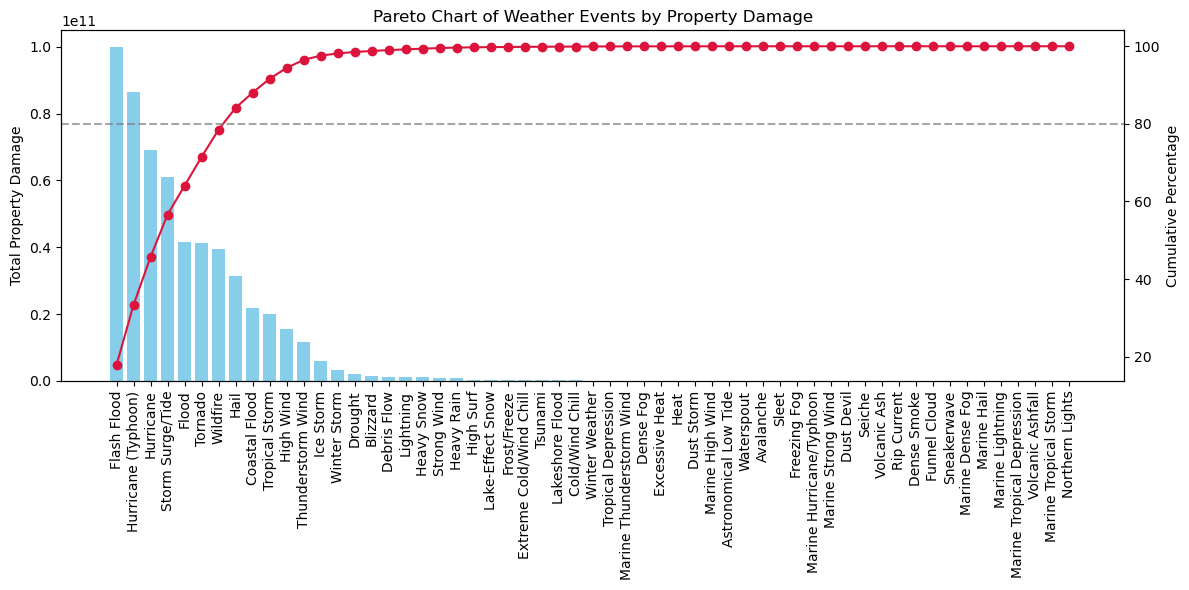

In [53]:
# we are going to make a Pareto chart to see if the 80/20 rule applies to weather events
#grouping by the sum of the total damage and the event type
damage_by_event = weather_df.groupby("EVENT_TYPE")["DAMAGE_PROPERTY_CLEAN"].sum().sort_values(ascending=False)

#calculating percentage 
percent_damage = damage_by_event.cumsum() / damage_by_event.sum() * 100

#plotting Pareto chart! First time for me
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.bar(damage_by_event.index, damage_by_event.values, color='skyblue')
ax1.set_ylabel("Total Property Damage")
ax1.set_xticks(range(len(damage_by_event)))
ax1.set_xticklabels(damage_by_event.index, rotation = 90)

ax2 = ax1.twinx()
ax2.plot(damage_by_event.index, percent_damage.values, color='crimson', marker = 'o')
ax2.set_ylabel("Cumulative Percentage")
ax2.axhline(80, color='gray', linestyle='--', alpha=0.7)

plt.title("Pareto Chart of Weather Events by Property Damage")
plt.tight_layout()
plt.show()

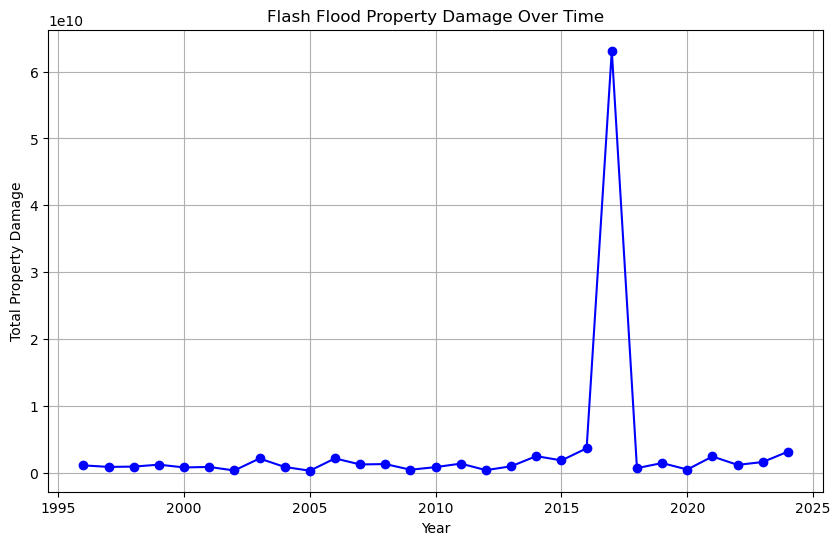

In [55]:
#Success!! That is a nice looking chart. We see that flash flooding is a huge economic strain
# we will look into that further here 
flash_flood_data = weather_df[weather_df['EVENT_TYPE'] == 'Flash Flood']
flash_flood_trends = flash_flood_data.groupby('YEAR').agg({
    'DAMAGE_PROPERTY_CLEAN': 'sum',
    'EVENT_TYPE': 'count'
}).reset_index()

#plotting flash flood property damage over time
plt.figure(figsize=(10, 6))
plt.plot(flash_flood_trends['YEAR'], flash_flood_trends['DAMAGE_PROPERTY_CLEAN'], color='blue', marker='o')
plt.title("Flash Flood Property Damage Over Time")
plt.xlabel("Year")
plt.ylabel("Total Property Damage")
plt.grid(True)
plt.show()

<Figure size 1200x600 with 0 Axes>

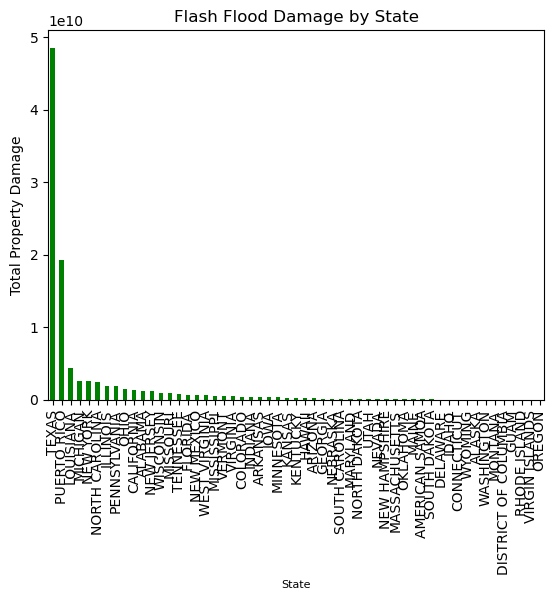

In [65]:
#that is not expected! we should look at geographic data to see maybe why there is this huge uptick in damage
flash_flood_by_state = flash_flood_data.groupby('STATE').agg({
    'DAMAGE_PROPERTY_CLEAN': 'sum',
    'EVENT_TYPE': 'count'
}).reset_index()

# plot by state 
plt.figure(figsize=(12, 6))
flash_flood_by_state.sort_values(by='DAMAGE_PROPERTY_CLEAN', ascending=False).plot.bar(x='STATE', y='DAMAGE_PROPERTY_CLEAN', color='green', legend=False)
plt.title("Flash Flood Damage by State")
plt.xlabel("State", fontsize=8) # i could not read the graph so adjusting font, turns out it did nothing. will keep as a reminder :(
plt.ylabel("Total Property Damage")
plt.xticks(rotation=90)
plt.show()


<Axes: title={'center': 'Total Property Damage by Year'}, xlabel='BEGIN_DATE_TIME'>

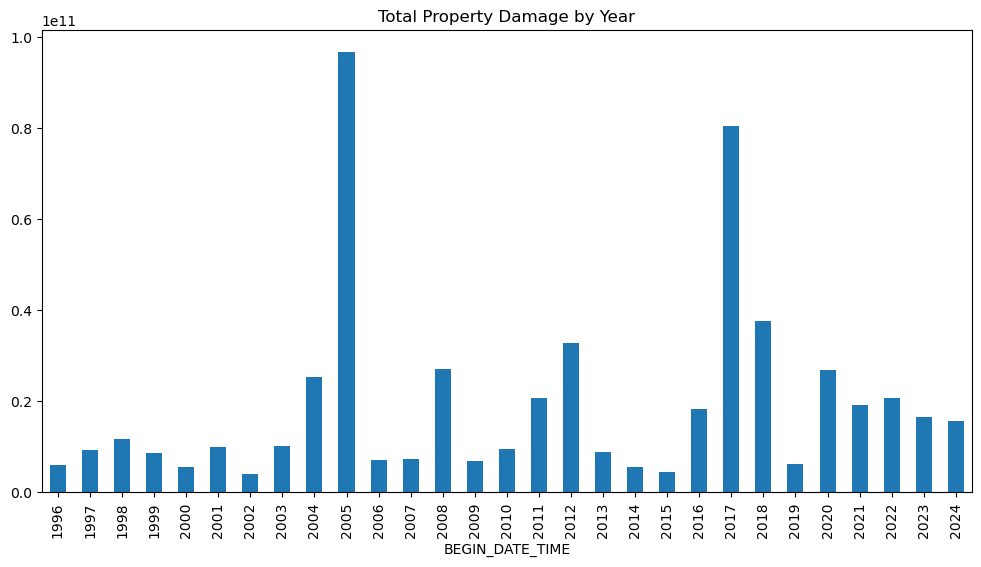

In [67]:
#so what happened in Texas? Turns out hurricane Harvey was in 2017. It caused massive flooding events all over Texas. 
#Time to decide if we are to use this or mark it as an outlier. Were there any other hurricanes that caused this damage level?
#checking damage by year 

damage_by_year = weather_df.groupby(weather_df["BEGIN_DATE_TIME"].dt.year)["DAMAGE_PROPERTY_CLEAN"].sum()
damage_by_year.plot(kind='bar', figsize=(12, 6), title='Total Property Damage by Year')


<Axes: title={'center': 'Total Property Damage in 2005, 2017, 2018'}, xlabel='BEGIN_DATE_TIME'>

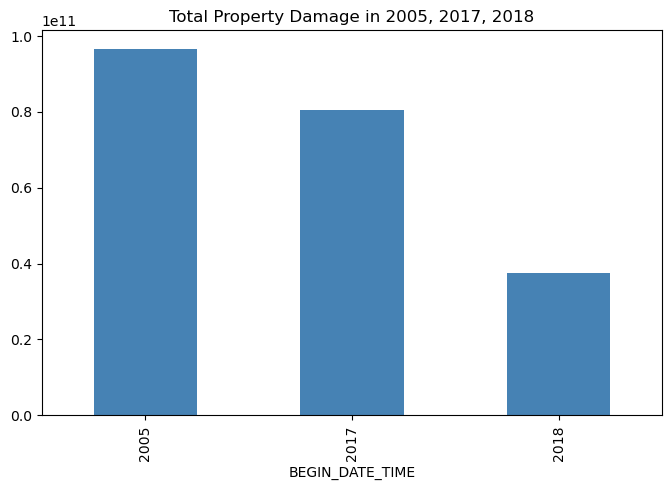

In [77]:
# let's look at 2005, 2017, and 2018
select_years = weather_df[weather_df["BEGIN_DATE_TIME"].dt.year.isin([2005, 2017, 2018])]
#calculates the sum of the property damage for each year selected 
damage_by_year = select_years.groupby(weather_df["BEGIN_DATE_TIME"].dt.year)["DAMAGE_PROPERTY_CLEAN"].sum()
damage_by_year.plot(kind='bar', figsize=(8, 5), color='steelblue', title='Total Property Damage in 2005, 2017, 2018')


<Axes: title={'center': 'Damage by State (2005, 2017, 2018)'}, ylabel='STATE'>

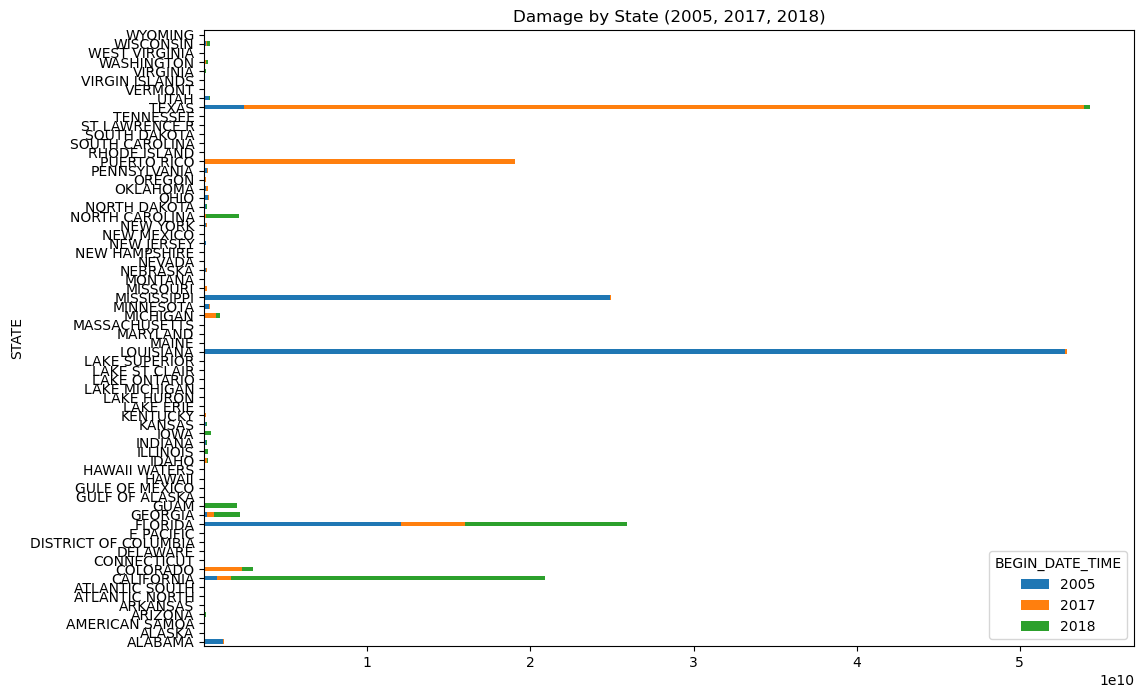

In [85]:
#checking states again for new grouping

damage_by_year_state = select_years.groupby(
    [weather_df["BEGIN_DATE_TIME"].dt.year, "STATE"]
)["DAMAGE_PROPERTY_CLEAN"].sum().unstack().fillna(0)


damage_by_year_state.T.plot(kind='barh', stacked=True, figsize=(12, 8), title="Damage by State (2005, 2017, 2018)")




In [ ]:
# 2005 damage was done in Louisianna and Mississippi, Hurricanes Katrina and Rita
#flooding caused by hurricanes, so hurricanes are our biggest weather economic strain 
